#### Spotify Data Analysis 
Thursday November 12th
Jack Krebsbach & Eli Edwards

#### Import all libraries needed for analysis

We will use various models to predict song popularity and classify which playlist genre a song came from.

In [188]:
# Imports for analysis
import pandas as pd
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from ISLP import confusion_table
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestRegressor as RF,RandomForestClassifier as RFC, GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import sklearn.model_selection as skm

#### Import Data

In [77]:
# Read in the CSV
df = pd.read_csv("./clean_data/spotify_songs.csv")

# Transform categorical data
df['playlist_genre'] = df['playlist_genre'].astype('category')
df['key'] = df['key'].astype('category')
df['mode'] = df['mode'].astype('category')
numeric_cols = df.select_dtypes(include=['number'])
df[numeric_cols.columns] = numeric_cols.astype('float64')

In [79]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66.0,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754.0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67.0,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600.0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70.0,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616.0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60.0,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093.0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69.0,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052.0


### Plot first two principal components of data


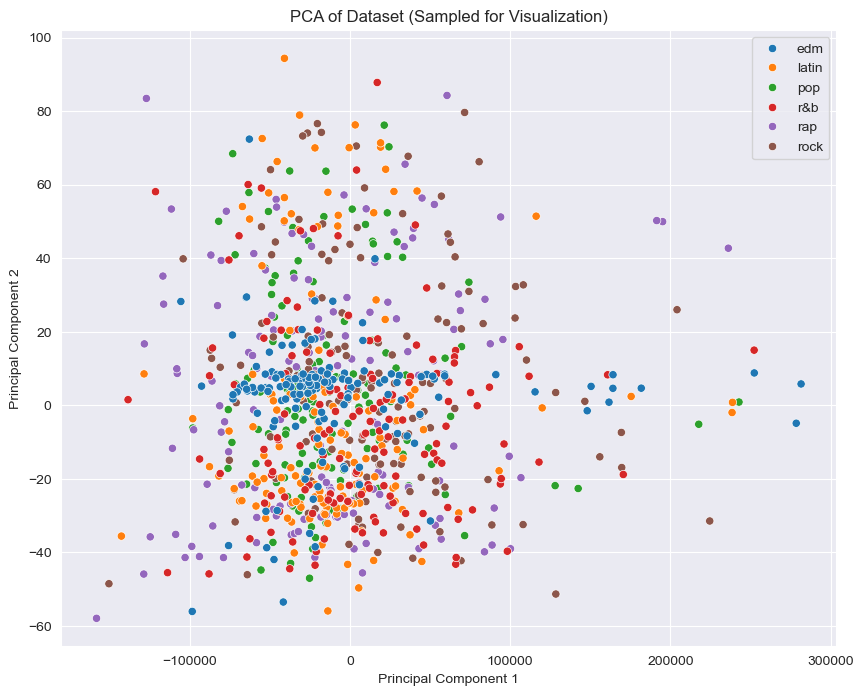

In [140]:
# Get the first two principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(numeric_cols)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['playlist_genre'] = df['playlist_genre'].values  # Ensure this column aligns with your PCA data


# Sample 150 points from each class for plotting
plot_df = pd.DataFrame()
for genre in pca_df['playlist_genre'].unique():
    sampled_genre_df = pca_df[pca_df['playlist_genre'] == genre].sample(n=150, random_state=42)
    plot_df = pd.concat([plot_df, sampled_genre_df], axis=0)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='playlist_genre', data=plot_df)
plt.title('PCA of Dataset (Sampled for Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

#### Create train/test split

In [154]:
(train, test) = skm.train_test_split(df, test_size=0.10, random_state=0, stratify=df.playlist_genre)

### Make model matrix for classification

In [81]:
# Predictors
cols = ['track_popularity',
        'danceability',
        'energy',
        'key',
        'loudness',
        'mode',
        'speechiness',
        'acousticness',
        'instrumentalness',
        'liveness',
        'valence',
        'tempo',
        'duration_ms']

In [82]:
# Training
x_train = train[cols]
genre_train = train.playlist_genre

In [83]:
# Testing
x_test = test[cols]
genre_test = test.playlist_genre

### K-Nearest Neighbors

For a baseline, we try and fit a K-Nearest-Neighbors model.

In [162]:
# Use approximately the square root of number of observations
#k = int(np.floor(np.sqrt(x_train.shape[0])))
k = 20
print(f'Using {k} neighbors')
# Initialize classifier
knn = KNeighborsClassifier(n_neighbors=k) 

# Fit the model
knn.fit(x_train, genre_train)

# Predict on the testing set
knn_pred = knn.predict(x_test)

# Get confusion table
confusion_table(knn_pred, genre_test)

Using 20 neighbors


Truth,edm,latin,pop,r&b,rap,rock
Predicted,,,,,,
edm,272,147,162,133,150,118
latin,65,78,88,90,53,54
pop,91,99,123,68,90,74
r&b,58,59,66,106,101,88
rap,70,73,53,79,125,58
rock,48,60,59,67,56,103


In [163]:
np.mean(knn_pred == genre_test)

0.24573690621193667

##### Tune KNN Model

We will tune the KNN to find the optimal K from 1 to $\lfloor \sqrt{n} \rfloor$ where $n$ is the number of observations in the test set.

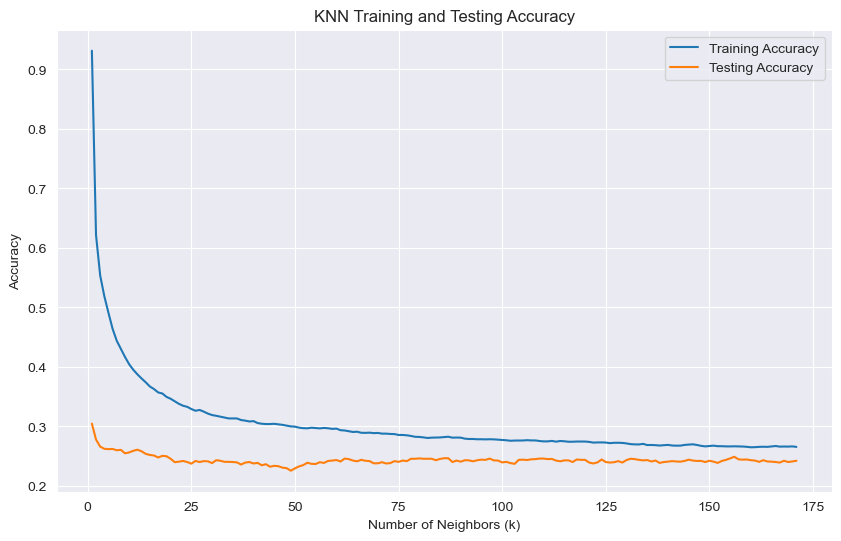

In [155]:
# Range of k to try
k_range = range(1, int(np.floor(np.sqrt(x_train.shape[0]))) + 1)

# Lists to store accuracies
train_accuracy = []
test_accuracy = []

# Loop over different values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, genre_train)

    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy.append(accuracy_score(genre_train, train_pred))

    # Testing accuracy
    test_pred = knn.predict(x_test)
    test_accuracy.append(accuracy_score(genre_test, test_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_accuracy, label='Training Accuracy')
plt.plot(k_range, test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Training and Testing Accuracy')
plt.legend()
plt.show()

#### LDA Classifier

In [189]:
# Instantiate the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the model
lda.fit(x_train, genre_train)

# Predict on new data
lda_pred = lda.predict(x_test)

# Confusion matrix
cm = confusion_matrix(genre_test, lda_pred)
print(cm)

[[369  59  89  19  39  29]
 [ 59 197  65  59  94  42]
 [ 81  96 168  71  39  96]
 [ 29  73  56 215 117  53]
 [ 78  73  37  61 299  27]
 [ 53  28  51  60   3 300]]


In [190]:
# Testing Accuracy
accuracy_score(genre_test, lda_pred)

0.4713763702801462

#### Random Forest

In [143]:
# Instantiate classifier instance
rfc = RFC(random_state=0, n_estimators=500,  min_samples_leaf=10)
# Fit the data
rfc.fit(x_train, genre_train)
# Predict on new data
rfc_pred = rfc.predict(x_test)
# Confusion matrix
cm = confusion_matrix(genre_test, rfc_pred)
cm

array([[438,  31,  68,  13,  28,  26],
       [ 35, 204,  80,  61, 105,  31],
       [ 99,  62, 182,  77,  39,  92],
       [ 21,  48,  43, 276, 115,  40],
       [ 32,  39,  28,  49, 402,  25],
       [ 24,  11,  40,  52,   8, 360]])

In [55]:
np.mean(rfc_pred == genre_test)

0.5724725943970768

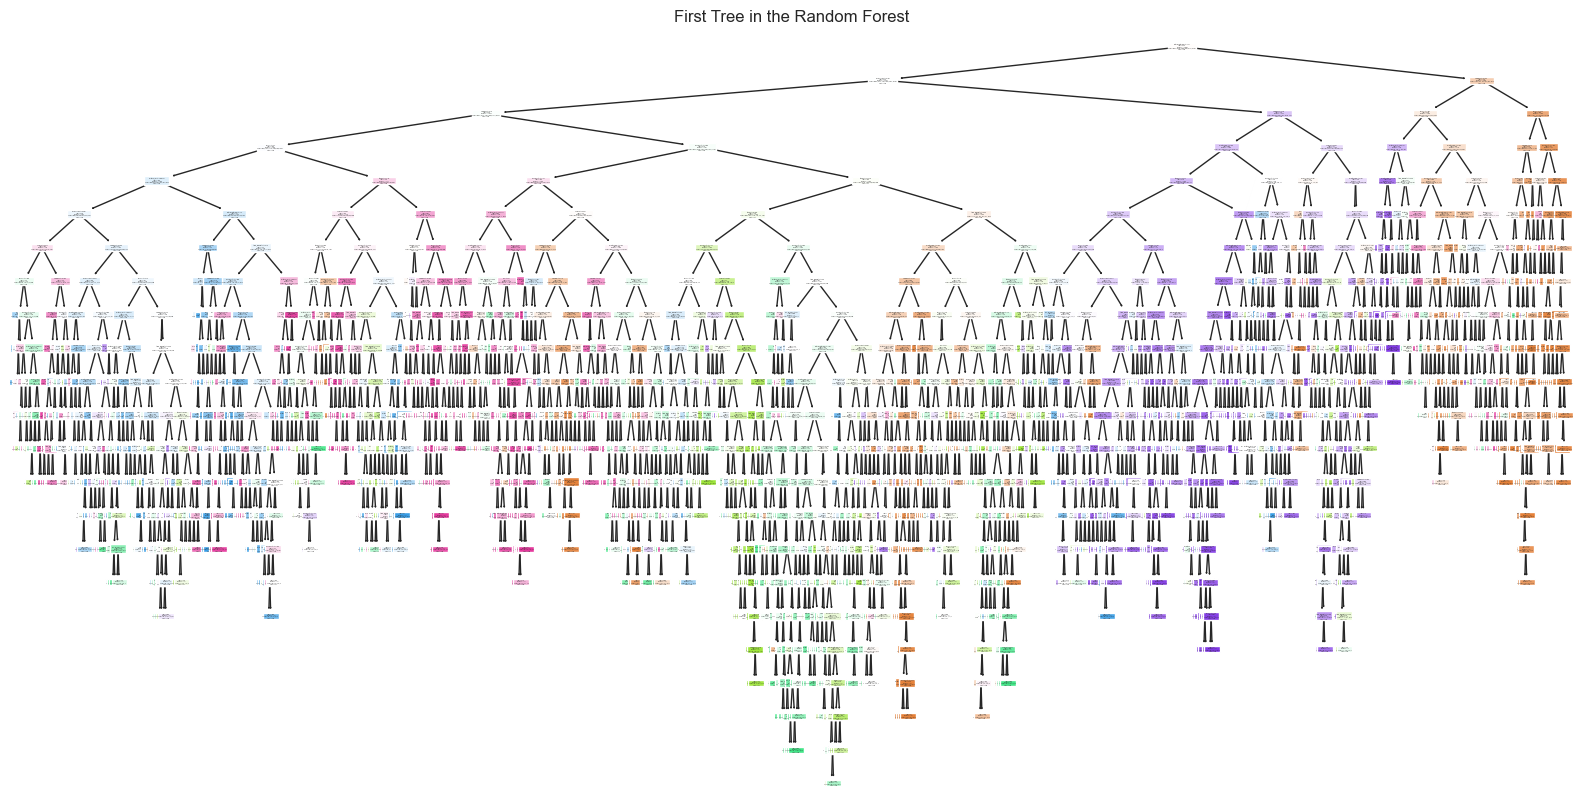

In [144]:
# Extract the first tree from the forest
first_tree = rfc.estimators_[0]

# Plot the first tree
plt.figure(figsize=(20,10))
plot_tree(first_tree, filled=True, feature_names=x_train.columns, class_names=True)
plt.title("First Tree in the Random Forest")
plt.show()

##### Tune Parameters for Random Forest

In [181]:
# Define Grid
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [4, 5, 6, 7, 8],
#     'criterion': ['gini',],
#     'min_samples_leaf': [1, 2, 4, 10]
# }
# 
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt'],
    'max_depth': [4, 5, 6],
    'criterion': ['gini'],
    'min_samples_leaf': [2]
}

In [182]:
rfc = RFC(random_state=0)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(x_train, genre_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 5, 6],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'n_estimators': [100, 200, 500]})

In [183]:
print("Best Parameters found by GridSearchCV:")
print(CV_rfc.best_params_)

Best Parameters found by GridSearchCV:
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500}


/var/folders/gf/bt25hkv172n_bttx0h72_6340000gn/T/ipykernel_91329/3965989055.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
/var/folders/gf/bt25hkv172n_bttx0h72_6340000gn/T/ipykernel_91329/3965989055.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")
/var/folders/gf/bt25hkv172n_bttx0h72_6340000gn/T/ipykernel_91329/3965989055.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")


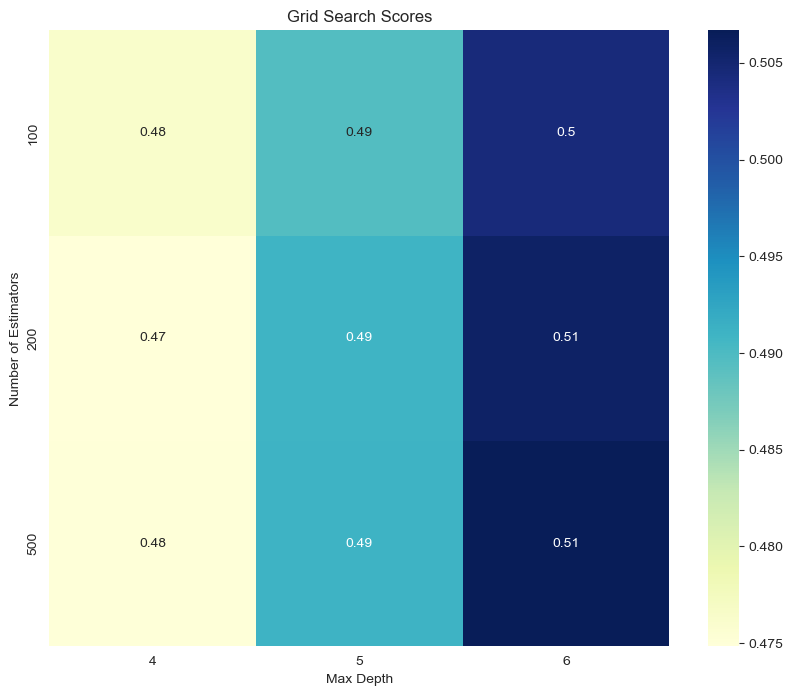

In [184]:
# Assuming 'param_grid' has two parameters, for example: 'n_estimators' and 'max_depth'
results = pd.DataFrame(CV_rfc.cv_results_)
pivot_table = results.pivot("param_n_estimators", "param_max_depth", "mean_test_score")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title("Grid Search Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

In [185]:
rfc_best = CV_rfc.best_estimator_
rfc_pred = rfc_best.predict(x_test)
cm = confusion_matrix(genre_test, rfc_pred)
print(cm)

[[438  27  54  19  36  30]
 [ 60 187  45  71 119  34]
 [113  85 108  94  55  96]
 [ 25  68  32 230 142  46]
 [ 41  49  24  53 375  33]
 [ 40  15  26  65   7 342]]


In [186]:
accuracy_score(genre_test,rfc_pred)

0.5115712545676004

#### XGBoost

In [129]:
# Instantiate Label Encoder
pd.options.mode.chained_assignment = None
le_genre = LabelEncoder()
le_key = LabelEncoder()

# Encode testing set
y_encoded = le_genre.fit_transform(genre_train)
x_train.loc[:,'key'] = le_key.fit_transform(x_train.key)

# Encode training set
y_test_encoded = le_genre.transform(genre_test)
x_test.loc[:,'key'] = le_key.transform(x_test.key)

In [134]:
# Instantiate the classifier
xg = xgb.XGBClassifier(enable_categorical = True)
# Fit the data
xg.fit(x_train, y_encoded) 
# Make prediction
xgb_pred = le_genre.transform(rfc.predict(x_test))
# Confusion Matrx
cm = confusion_matrix(y_test_encoded, xgb_pred)
cm

array([[438,  31,  68,  13,  28,  26],
       [ 35, 204,  80,  61, 105,  31],
       [ 99,  62, 182,  77,  39,  92],
       [ 21,  48,  43, 276, 115,  40],
       [ 32,  39,  28,  49, 402,  25],
       [ 24,  11,  40,  52,   8, 360]])

In [135]:
# Get accuracy
np.mean(xgb_pred == y_test_encoded)

0.5669914738124239